In [2]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'games_played', 'round']
sub_cols = ['current_formation', 'avg_goals_against', 'goal_diff', 'win_percentage', 'sos',
           'opp_win_percentage', 'opp_sos', 'current_team_yellow_cards', 'current_team_corner_kicks', 'current_team_first_half_goals', 'current_team_sec_half_goals', 
           'opp_team_yellow_cards', 'opp_team_corner_kicks', 'opp_team_first_half_goals', 'opp_team_sec_half_goals']

all_models = ['log', 'svc', 'gmm', 'knn', 'gnb', 'randomForest']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


In [3]:
data_csv = 'raw_data.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)
print('Data Loaded...')
print("Dataset size :: {}".format(raw_data.shape))
display(raw_data.head())

Data Loaded...
Dataset size :: (634, 24)


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goals_for,goals_allowed,opp_goals_for,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,rpi,opp_rpi,goals,points
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,4,5,2,5,0.114286,0.750000,0.587097,0.524917,1.210938,1.037931,0.630952,0.477444,3,3
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-2-3-1,5,5,2,4,0.156250,0.818182,0.502976,0.538136,1.183099,0.874074,0.465919,0.407233,1,1
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,6,1,4,5,0.133333,0.821429,0.495575,0.504323,1.185315,1.074303,0.547723,0.456140,2,1
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,6,3,4,7,0.146341,0.695652,0.467742,0.609907,1.148148,1.247104,0.497669,0.573715,3,3
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,6,3,4,2,0.146341,0.942857,0.467742,0.534946,1.148148,1.053824,0.497669,0.523888,2,3


## FORMATTING

In [4]:
# Helper Function - Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

""" Need to do some formatting of the Data before we run the models"""
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

rankings_data = raw_data.copy()

rankings_data["offensive_ranking"] = pd.Series(None, index=rankings_data.index)
rankings_data["opp_defensive_ranking"] = pd.Series(None, index=rankings_data.index)
rankings_data["rpi_ranking"] = pd.Series(None, index=rankings_data.index)
rankings_data["opp_rpi_ranking"] = pd.Series(None, index=rankings_data.index)

leagues = model_libs.get_leagues_country_codes()
#leagues = { "epl": 'ENG' }
teams = form_data.get_teams()
league_rounds = model_libs.get_leagues_rounds()
test = True
if test:
    """ Going through each League"""
    for key, value in leagues.iteritems():
        print(key)
        country_code = leagues[key]
        round_num = league_rounds[key]
        #round_num = 6
        teams_in_league = teams[teams["country_code"] == country_code]
        """ Looping through the Rounds """
        for i in range(4, round_num):
            print("ROUND :: {} ".format(i))
            
            rpi_rankings = form_data.get_rankings(teams_in_league, i, "rpi", False)
            r_rankings = model_libs.quartile_list(rpi_rankings, True)
            rpi_rankings["rpi_rankings_quartiled"] = r_rankings
            #print(rpi_rankings)
            print("Finished with RPI Rankings")
            
            offensive_rankings = form_data.get_rankings(teams_in_league, i, "offensive", False)
            rankings = model_libs.quartile_list(offensive_rankings, True)
            offensive_rankings["offensive_rankings_quartiled"] = rankings
            print("Finished with Offensive Rankings")
            #print(offensive_rankings)

            defensive_rankings = form_data.get_rankings(teams_in_league, i, "defensive", False)
            rankings = model_libs.quartile_list(defensive_rankings, False)
            defensive_rankings["defensive_rankings_quartiled"] = rankings
            print("Finished with Defensive Rankings")
            #print(defensive_rankings)

            """ Loop through each Team in the League for that round and assign an Offensive Rank """
            for key, team in teams_in_league.iterrows():
                
                ''' Assigning RPI Rankings to the Current Team and the Opponent Team '''
                rpi_rank = rpi_rankings.loc[rpi_rankings[0] == team['id'], "rpi_rankings_quartiled"]
                
                r_idx = rankings_data.loc[(rankings_data["team_id"] == team["id"]) 
                        & (rankings_data["round"] == (i)), "rpi_ranking"].index
               
                opp_r_idx = rankings_data.loc[(rankings_data["opp_id"] == team["id"]) 
                        & (rankings_data["round"] == (i)), "rpi_ranking"].index

                rankings_data.set_value(r_idx, "rpi_ranking", rpi_rank.values[0])
                rankings_data.set_value(opp_r_idx, "opp_rpi_ranking", rpi_rank.values[0])
                
                ''' If the team is the team_id then put in their offensive ranking for that game '''
                offensive_rank = offensive_rankings.loc[offensive_rankings[0] == team['id'], "offensive_rankings_quartiled"]
                idx = rankings_data.loc[(rankings_data["team_id"] == team["id"]) 
                        & (rankings_data["round"] == (i)), "offensive_ranking"].index

                rankings_data.set_value(idx, "offensive_ranking", offensive_rank.values[0])
                ''' If the team is the opp then put in their defensive ranking for that game '''
                defensive_rank = defensive_rankings.loc[defensive_rankings[0] == team['id'], "defensive_rankings_quartiled"]
                opp_idx = rankings_data.loc[(rankings_data["opp_id"] == team["id"]) 
                        & (rankings_data["round"] == (i))].index

                rankings_data.set_value(opp_idx, "opp_defensive_ranking", defensive_rank.values[0])
                
                rankings_data.to_csv('rankings_data.csv')
                
else:
    
    rankings_data = pd.read_csv('rankings_data.csv')
    rankings_data = rankings_data.drop(rankings_data.columns[[0]], axis=1)
    
print('Data Loaded...')
                          
""" Formatting data to convert goals scored to the correct category"""
# Not using points as a target for this version, using goals
rankings_data = rankings_data.drop('goals', 1)

#rankings_data['converted_goals'] = rankings_data.apply(lambda row: model_libs.set_group(row['goals']), axis=1)

rankings_data = rankings_data.drop(ignore_cols + ['current_formation'], 1)
display(rankings_data.head())

primera_division
ROUND :: 4 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
mls
ROUND :: 4 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 5 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 6 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 7 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 8 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensiv

/Users/senzari/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 15 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 16 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 17 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 18 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 19 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ROUND :: 20 
Rankings :: rpi
Fini

,is_home,goals_for,goals_allowed,opp_goals_for,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,rpi,opp_rpi,points,offensive_ranking,opp_defensive_ranking,rpi_ranking,opp_rpi_ranking
0,0,4,5,2,5,0.114286,0.750000,0.587097,0.524917,1.210938,1.037931,0.630952,0.477444,3,1,0.66666,0.66666,0.00000
1,1,5,5,2,4,0.156250,0.818182,0.502976,0.538136,1.183099,0.874074,0.465919,0.407233,1,1,0.33333,0.33333,0.66666
2,1,6,1,4,5,0.133333,0.821429,0.495575,0.504323,1.185315,1.074303,0.547723,0.456140,1,1,0.00000,0.66666,0.33333
3,0,6,3,4,7,0.146341,0.695652,0.467742,0.609907,1.148148,1.247104,0.497669,0.573715,3,1,0.33333,0.66666,0.66666
4,1,6,3,4,2,0.146341,0.942857,0.467742,0.534946,1.148148,1.053824,0.497669,0.523888,3,1,0.33333,0.66666,0.33333


In [5]:
rankings_data.to_csv('rankings_fully_formatted.csv')

In [56]:
rankings_data = pd.read_csv('rankings_fully_formatted.csv')
rankings_data = rankings_data.drop(rankings_data.columns[[0]], axis=1)
display(rankings_data.head(1))

,is_home,goals_for,goals_allowed,opp_goals_for,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,rpi,opp_rpi,points,offensive_ranking,opp_defensive_ranking,rpi_ranking,opp_rpi_ranking
0,0,4,5,2,5,0.114286,0.75,0.587097,0.524917,1.210938,1.037931,0.630952,0.477444,3,1,0.66666,0.66666,0


### RUNNING CLASSIFICATION MODEL

In [57]:
def run_features(data, drop_data, target, models):
    
    new_data = data.drop(drop_data, axis=1)
    
    #display(new_data.head())
    
    (y, X) = model_libs._extract_target(new_data, target)
    
    models = form_model.train_models(round_number, X, y, models)
    
    return models


rankings_data['diff_goal_for'] = rankings_data.apply(lambda r: np.subtract(np.square(r['goals_for']), np.square(r['opp_goals_for'])), axis=1)
rankings_data['diff_goal_allowed'] = rankings_data.apply(lambda r: np.subtract(np.square(r['goals_allowed']), np.square(r['opp_goals_allowed'])), axis=1)
rankings_data = rankings_data.drop(['goals_for', 'goals_allowed', 'opp_goals_for', 'opp_goals_allowed', 'rpi', 'opp_rpi', 'rpi_ranking', 'opp_rpi_ranking'], 1)

display(rankings_data.head(1))

#### Running ALL Features 
models_test_1 = run_features(rankings_data, [], 'points', ["knn"])

(rankings_y, rankings_X) = model_libs._extract_target(rankings_data, 'points')

def check_accuracy(model, data_X):
    actual_y = pd.DataFrame(rankings_y.values, columns=['actual'])
    predictions = pd.DataFrame(model.predict(data_X), columns=['predictions'])
    preds = pd.concat([predictions, actual_y], axis=1)
    preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['predictions'], r['actual']), axis=1)
    accuracy = np.divide(preds['diff'].sum(), float(len(preds['diff'])))
    print(accuracy)

for m in models_test_1:
    check_accuracy(m, rankings_X)

,is_home,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,points,offensive_ranking,opp_defensive_ranking,diff_goal_for,diff_goal_allowed
0,0,0.114286,0.75,0.587097,0.524917,1.210938,1.037931,3,1,0.66666,12,0


-----------------------------------
Training K Neighbors Classifier Model
KNN Score on Training Set :: 0.660749506903
KNN Score on Test Set:: 0.291338582677
Finished K-Means Modeling
0.586750788644


In [58]:
def create_RFE(X, y):
    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit(X, y)
    print(rfe.ranking_)
    return rfe.ranking_


# Taking all of Home/Away Data (even the Extended Features)
rankings = create_RFE(rankings_X, rankings_y)

[ 1  3  6  4  2  8  7  9  5 10 11]


In [59]:
""" Reordering the columns in the data to reflect the rankings """

rankings_name = []
ranked_X = rankings_X

for r in range(len(rankings)):
    column_name = rankings_X.iloc[:, rankings[r]-1].name
    rankings_name.append(column_name)

ranked_X = ranked_X.reindex_axis(rankings_name, axis=1)
display(ranked_X.head())

,is_home,opp_defensive_goal_efficiency,ratio_ball_safe_to_dangerous_attacks,ratio_of_attacks,goal_efficiency,offensive_ranking,opp_ratio_ball_safe_to_dangerous_attacks,opp_defensive_ranking,opp_ratio_of_attacks,diff_goal_for,diff_goal_allowed
0,0,0.750000,1.210938,0.587097,0.114286,1,1.037931,0.66666,0.524917,12,0
1,1,0.818182,1.183099,0.502976,0.156250,1,0.874074,0.33333,0.538136,21,9
2,1,0.821429,1.185315,0.495575,0.133333,1,1.074303,0.00000,0.504323,20,-24
3,0,0.695652,1.148148,0.467742,0.146341,1,1.247104,0.33333,0.609907,20,-40
4,1,0.942857,1.148148,0.467742,0.146341,1,1.053824,0.33333,0.534946,20,5


Index([u'is_home', u'goal_efficiency', u'opp_defensive_goal_efficiency',
       u'ratio_of_attacks', u'opp_ratio_of_attacks',
       u'ratio_ball_safe_to_dangerous_attacks',
       u'opp_ratio_ball_safe_to_dangerous_attacks', u'offensive_ranking',
       u'opp_defensive_ranking', u'diff_goal_for', u'diff_goal_allowed'],
      dtype='object')


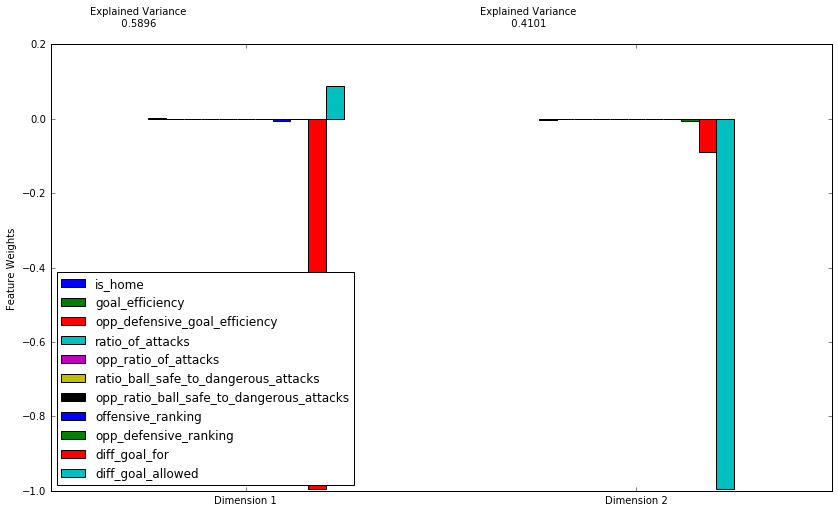

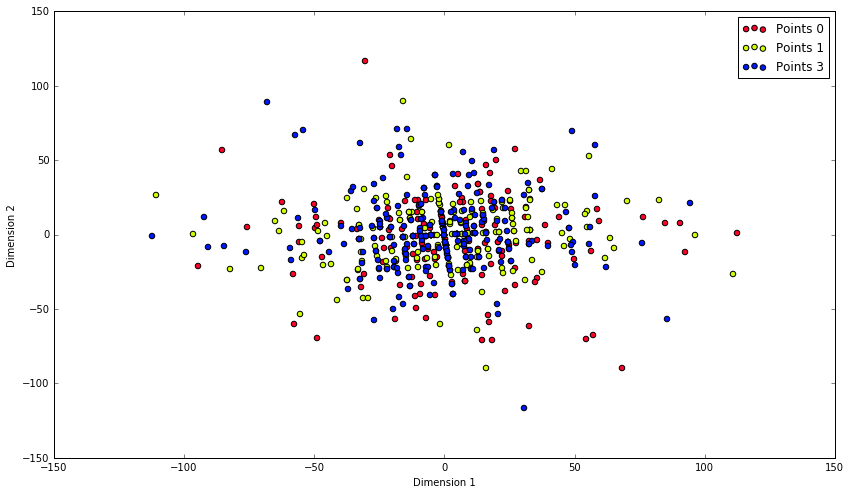

In [79]:
def plot_PCA(data, preds):
    
    pca = PCA(n_components=2)
    pca.fit(data)
    
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    #print(pca_results)
    pca_data = pca.transform(data)
    
    # Create a DataFrame for the reduced data
    pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])
    plot_data = pd.concat([preds, pca_data], axis = 1)
    
    # Scatterplotting the transformed data if it's 2 Dimensions
    fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('points'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);
    
    return pca, plot_data, pca_results

print(rankings_X.columns)
pca, pca_data, pca_results = plot_PCA(rankings_X, rankings_y)

In [80]:
pca_models = run_features(pca_data, [], 'points', ['svc'])
#models_test_1 = run_features(rankings_data, [], 'points', ["knn"])
(pca_y, pca_X) = model_libs._extract_target(pca_data, 'points')
svc_pca = pca_models[0]

-----------------------------------
Training SVC Model
F1 score for training set: 0.278637993691
F1 score for test set: 0.27085650723
Finished SVC Modeling


In [61]:
log_model = form_model.build_tuned_model(rankings_X, rankings_y, 'log')

for m in log_model:
    print(m)
    check_accuracy(m, rankings_X)

Training LOG REG Model
Score on Training Set :: 0.495069033531
Score on Test Set :: 0.503937007874
Finished LOG REG Modeling
LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.496845425868


In [62]:
random_forest_model = form_model.build_tuned_model(rankings_X, rankings_y, 'randomForest')

for m in random_forest_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training Random Forest Model
[ 0.41747573  0.47058824  0.48514851  0.47524752  0.44      ]
Accuracy: 0.46 (+/- 0.05)
Finished Random Forest Modeling
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features=2,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.673501577287


In [63]:
knn_model = form_model.build_tuned_model(rankings_X, rankings_y, 'knn')

for m in knn_model:
    check_accuracy(m, rankings_X)

-----------------------------------
Training K-Means Model
KNN Score :: 0.659405940594 for Training
KNN Score :: 0.232558139535 for Testing
KNN Score :: 0.666666666667 for Training
KNN Score :: 0.275590551181 for Testing
KNN Score :: 0.663385826772 for Training
KNN Score :: 0.357142857143 for Testing
KNN Score :: 0.655511811024 for Training
KNN Score :: 0.301587301587 for Testing
KNN Score :: 0.622047244094 for Training
KNN Score :: 0.349206349206 for Testing
Finished K-Means Modeling
0.567823343849


In [64]:
gnb_model = form_model.build_tuned_model(rankings_X, rankings_y, 'gnb')

for m in gnb_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training Gaussian NB Model
[ 0.45631068  0.47058824  0.54455446  0.51485149  0.53      ]
Accuracy: 0.50 (+/- 0.07)
Finished Gaussian NB Modeling
GaussianNB()
0.48738170347


In [65]:
svc_model = form_model.build_tuned_model(rankings_X, rankings_y, 'svc')

display(rankings_X.columns)
for m in svc_model:
    print(m)
    check_accuracy(m, rankings_X)

Training and Tuning SVC Model
[ 0.30314961  0.28853755]
Accuracy: 0.30 (+/- 0.01)
Finished SVC Modeling


Index([u'is_home', u'goal_efficiency', u'opp_defensive_goal_efficiency',
       u'ratio_of_attacks', u'opp_ratio_of_attacks',
       u'ratio_ball_safe_to_dangerous_attacks',
       u'opp_ratio_ball_safe_to_dangerous_attacks', u'offensive_ranking',
       u'opp_defensive_ranking', u'diff_goal_for', u'diff_goal_allowed'],
      dtype='object')

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
0.824921135647


In [66]:
gmm_model = form_model.build_tuned_model(rankings_X, rankings_y, 'gmm')

for m in gmm_model:
    print(m)
    check_accuracy(m, rankings_X)

-----------------------------------
Training and Tuning GMM Model
W/ Covariance Type :: spherical
# of Components :: 2
Silhouette Score :: 0.319632057171 for Training
Silhouette Score :: 0.318221913285 for Testing
# of Components :: 3
Silhouette Score :: 0.21012755702 for Training
Silhouette Score :: 0.119683004063 for Testing
# of Components :: 4
Silhouette Score :: 0.203606701149 for Training
Silhouette Score :: 0.0735598309649 for Testing
W/ Covariance Type :: tied
# of Components :: 2
Silhouette Score :: 0.218589903871 for Training
Silhouette Score :: 0.246332840991 for Testing
# of Components :: 3
Silhouette Score :: 0.0838075427847 for Training
Silhouette Score :: 0.0659595476268 for Testing
# of Components :: 4
Silhouette Score :: 0.183400190409 for Training
Silhouette Score :: 0.164312900797 for Testing
W/ Covariance Type :: diag
# of Components :: 2
Silhouette Score :: 0.428700464565 for Training
Silhouette Score :: 0.420548358166 for Testing
# of Components :: 3
Silhouette Sc

Cross Validating the SVC model with the PCA data to help prevent overfitting

In [68]:
prediction_models = form_model.load_models(['knn', 'svc', 'randomForest', 'gnb', 'gmm', 'log'])

Success :: Loaded - knn
Success :: Loaded - svc
Success :: Loaded - randomForest
Success :: Loaded - gnb
Success :: Loaded - gmm
Success :: Loaded - log


In [70]:
print('Upcoming matches')
#upcoming_matches, match_details = predict_matches.get_upcoming_matches()
#upcoming_matches.to_csv('upcoming_matches.csv')
upcoming_matches = pd.read_csv('upcoming_matches.csv')
upcoming_matches = upcoming_matches.drop(upcoming_matches.columns[[0]], axis=1)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
upcoming_data = predict_matches.predictions(upcoming_matches)
print('Data Loaded and Predicted...')

display(upcoming_data.head(1))

upcoming_data['diff_goal_for'] = upcoming_data.apply(lambda r: np.subtract(np.square(r['goals_for']), np.square(r['opp_goals_for'])), axis=1)
upcoming_data['diff_goal_allowed'] = upcoming_data.apply(lambda r: np.subtract(np.square(r['goals_allowed']), np.square(r['opp_goals_allowed'])), axis=1)
upcoming_data = upcoming_data.drop(['goals_for', 'goals_allowed', 'opp_goals_for', 'opp_goals_allowed', 'rpi'], 1)

upcoming_data["offensive_ranking"] = pd.Series(None, index=rankings_data.index)
upcoming_data["opp_defensive_ranking"] = pd.Series(None, index=rankings_data.index)
upcoming_data["rpi_ranking"] = pd.Series(None, index=rankings_data.index)
upcoming_data["opp_rpi_ranking"] = pd.Series(None, index=rankings_data.index)

leagues = model_libs.get_leagues_country_codes()
teams = form_data.get_teams()
league_rounds = model_libs.get_leagues_rounds()
test = True
if test:
    """ Going through each League"""
    for key, value in leagues.iteritems():
        print(key)
        country_code = leagues[key]
        round_num = league_rounds[key]
        teams_in_league = teams[teams["country_code"] == country_code]
        
        print("ROUND :: {} ".format(round_num))
        
        rpi_rankings = form_data.get_rankings(teams_in_league, round_num, "rpi", True)
        r_rankings = model_libs.quartile_list(rpi_rankings, True)
        rpi_rankings["rpi_rankings_quartiled"] = r_rankings
        #print(rpi_rankings)
        print("Finished with RPI Rankings")
        
        offensive_rankings = form_data.get_rankings(teams_in_league, round_num, "offensive", True)
        rankings = model_libs.quartile_list(offensive_rankings, True)
        offensive_rankings["offensive_rankings_quartiled"] = rankings
        #print(offensive_rankings)
        print("Finished with Offensive Rankings")

        defensive_rankings = form_data.get_rankings(teams_in_league, round_num, "defensive", True)
        rankings = model_libs.quartile_list(defensive_rankings, False)
        defensive_rankings["defensive_rankings_quartiled"] = rankings
        #print(defensive_rankings)
        print("Finished with Defensive Rankings")

        """ Loop through each Team in the League for that round and assign an Offensive Rank """
        for key, team in teams_in_league.iterrows():
            
            ''' Assigning RPI Rankings to the Current Team and the Opponent Team '''
            rpi_rank = rpi_rankings.loc[rpi_rankings[0] == team['id'], "rpi_rankings_quartiled"]
            r_idx = upcoming_data.loc[(upcoming_data["team_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num)), "rpi_ranking"].index
            opp_r_idx = upcoming_data.loc[(upcoming_data["opp_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num)), "rpi_ranking"].index
            
            upcoming_data.set_value(r_idx, "rpi_ranking", rpi_rank.values[0])
            upcoming_data.set_value(opp_r_idx, "opp_rpi_ranking", rpi_rank.values[0])
                
            ''' If the team is the team_id then put in their offensive ranking for that game '''
            offensive_rank = offensive_rankings.loc[offensive_rankings[0] == team['id'], "offensive_rankings_quartiled"]
            idx = upcoming_data.loc[(upcoming_data["team_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num)), "offensive_ranking"].index
            upcoming_data.set_value(idx, "offensive_ranking", offensive_rank.values[0])
            
            ''' If the team is the opp then put in their defensive ranking for that game '''
            defensive_rank = defensive_rankings.loc[defensive_rankings[0] == team['id'], "defensive_rankings_quartiled"]
            opp_idx = upcoming_data.loc[(upcoming_data["opp_id"] == team["id"]) 
                    & (upcoming_data["round"] == (round_num))].index

            upcoming_data.set_value(opp_idx, "opp_defensive_ranking", defensive_rank.values[0])
                
        upcoming_data.to_csv('upcoming_formatted_matches.csv')
                
else:
    
    upcoming_data = pd.read_csv('upcoming_formatted_matches.csv')
    upcoming_data = upcoming_data.drop(upcoming_data.columns[[0]], axis=1)



print('Added Rankings to Upcoming Matches')

Upcoming matches
Data Loaded and Predicted...


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goals_for,goals_allowed,opp_goals_for,opp_goals_allowed,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,rpi,goals,points
0,900,21,FC Dallas,23,Real Salt Lake,2016-09-25 01:30:00,28,3,0,4-2-3-1,5,4,3,5,0.128205,0.782609,0.541528,0.396947,1.264706,0.97037,0.506589,0,0


primera_division
ROUND :: 5 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
mls
ROUND :: 28 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
epl
ROUND :: 6 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
bundesliga
ROUND :: 5 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
ligue_1
ROUND :: 7 
Rankings :: rpi
Finished with RPI Rankings
Rankings :: offensive
Finished with Offensive Rankings
Rankings :: defensive
Finished with Defensive Rankings
Added Rankings to Upcoming Matches


In [76]:
""" Need to remove the same columns from the data the same way we did on the raw data """
upcoming_formatted_data = upcoming_data.drop(['goals'], 1)

upcoming_formatted_data = upcoming_formatted_data.drop(ignore_cols + ['current_formation', 'points', 'rpi_ranking', 'opp_rpi_ranking'], 1)
#display(upcoming_formatted_data.columns)
display(upcoming_formatted_data.head())

,is_home,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,diff_goal_for,diff_goal_allowed,offensive_ranking,opp_defensive_ranking
0,0,0.128205,0.782609,0.541528,0.396947,1.264706,0.970370,16,-9,1.00000,1.00000
1,0,0.041667,0.896552,0.482993,0.591973,1.050000,1.150000,-8,-5,0.00000,0.66666
2,1,0.088235,0.800000,0.561934,0.480263,1.153310,0.924012,-16,9,0.33333,1.00000
3,1,0.214286,0.888889,0.480263,0.490506,0.924012,1.029316,0,33,0.33333,0.33333
4,0,0.064516,0.791667,0.422713,0.505119,1.096886,1.042705,-21,11,0.33333,1.00000


In [81]:
print(upcoming_formatted_data.columns)
pca_data = pca.transform(upcoming_formatted_data)
svc_pca_preds = svc_pca.predict(pca_data)
print(svc_pca_preds)

Index([u'is_home', u'goal_efficiency', u'opp_defensive_goal_efficiency',
       u'ratio_of_attacks', u'opp_ratio_of_attacks',
       u'ratio_ball_safe_to_dangerous_attacks',
       u'opp_ratio_ball_safe_to_dangerous_attacks', u'diff_goal_for',
       u'diff_goal_allowed', u'offensive_ranking', u'opp_defensive_ranking'],
      dtype='object')
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.]


In [82]:
""" Models we'll use to predict on upcoming matches """
# pca_svc_model, knn_model, random_forest_model

# This is all the X values
upcoming_formatted_data
display(upcoming_formatted_data.head(1))

svc_preds = prediction_models[1].predict(upcoming_formatted_data)
svc_decsions = prediction_models[1].decision_function(upcoming_formatted_data)
svc_probs = prediction_models[1].predict_proba(upcoming_formatted_data)

print(svc_decsions.shape)
decisions = pd.DataFrame(svc_decsions)
display(decisions.head(1))
probs = pd.DataFrame(svc_probs)
probs = probs.rename(columns={0: "A", 1: "B", 2: "C"})
display(probs.head(1))
#display(decisions)
#print(svc_decsions)

rf_preds = prediction_models[2].predict(upcoming_formatted_data)
print(rf_preds)
knn_preds = prediction_models[0].predict(upcoming_formatted_data)
print(knn_preds)

gmm_preds = prediction_models[3].predict(upcoming_formatted_data)
print(gmm_preds)

gnb_preds = prediction_models[4].predict(upcoming_formatted_data)
print(gnb_preds)

log_preds = prediction_models[5].predict(upcoming_formatted_data)
print(log_preds)


,is_home,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,diff_goal_for,diff_goal_allowed,offensive_ranking,opp_defensive_ranking
0,0,0.128205,0.782609,0.541528,0.396947,1.264706,0.97037,16,-9,1,1


(98, 3)


,0,1,2
0,0.069231,-0.014377,-0.067313


,A,B,C
0,0.343668,0.30953,0.346802


[ 3.  1.  3.  0.  0.  0.  0.  3.  1.  1.  3.  3.  3.  1.  0.  1.  0.  3.
  3.  1.  0.  1.  3.  1.  3.  0.  3.  0.  3.  0.  3.  1.  3.  1.  3.  3.
  0.  3.  1.  0.  1.  0.  0.  0.  0.  1.  1.  3.  3.  3.  0.  1.  3.  1.
  0.  1.  0.  3.  3.  3.  0.  0.  3.  3.  3.  3.  3.  1.  0.  3.  0.  3.
  3.  1.  3.  1.  0.  1.  3.  0.  0.  3.  0.  0.  3.  1.  3.  0.  3.  0.
  3.  3.  1.  1.  3.  1.  0.  0.]
[ 0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  3.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  3.  0.  0.  0.  0.  3.  0.  0.  1.  1.  0.  0.  3.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  3.  0.
  3.  1.  0.  3.  0.  0.  0.  0.]
[ 3.  0.  0.  3.  0.  0.  3.  0.  3.  3.  3.  3.  3.  3.  3.  3.  0.  3.
  3.  3.  3.  0.  0.  0.  0.  3.  3.  0.  3.  0.  0.  0.  0.  3.  0.  0.
  0.  0.  0.  0.  3.  3.  3.  0.  3.  3.  0.  3.  3.  3.

In [83]:
columns = ['team_name', 'opp_name', 'scheduled']
# Remove all columns except the ones above
#upcoming_matches = upcoming_data[columns]
upcoming_matches = upcoming_data

#random_preds = pd.Series(np.random.randint(3, size=len(upcoming_matches.index)), upcoming_matches.index)
#random_preds[random_preds == 2] = 3

# Add predictions to the end of that DF
results = pd.DataFrame({'KNN': knn_preds, 'RandomForest': rf_preds, 'GNB': gnb_preds, 'GMM': gmm_preds, 'log': log_preds, 'SVC': svc_preds, 'SVC_PCA': svc_pca_preds})

upcoming_matches = pd.concat([upcoming_matches, results, decisions, probs], axis = 1)
display(upcoming_matches.head(1))
reordered_matches = pd.DataFrame([])

for rows in upcoming_matches.iterrows():
    for i in upcoming_matches['team_name']:
        if rows[1]['opp_name'] == i:
            reordered_matches = reordered_matches.append(rows[1])
            reordered_matches = reordered_matches.append(upcoming_matches[upcoming_matches['team_name'].isin([i])])

reordered_matches = reordered_matches.drop_duplicates() 
columns = ['scheduled', 'team_name', 'opp_name', 'is_home', 'diff_goal_for', 'diff_goal_allowed', 'rpi_ranking', 'opp_rpi_ranking', 
           'goal_efficiency', 'opp_defensive_goal_efficiency', 'ratio_of_attacks', 
           'opp_ratio_of_attacks', 'ratio_ball_safe_to_dangerous_attacks', 'opp_ratio_ball_safe_to_dangerous_attacks', 
           'offensive_ranking', 'opp_defensive_ranking', 'KNN', 'RandomForest', 'GNB', 'GMM', 'log', 'SVC_PCA', 'SVC', 0, 1, 2, 'A', 'B', 'C']
reordered_matches = reordered_matches[columns]
reordered_matches.to_csv('predictions_on_upcoming.csv')
print('Prediction CSV saved')

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,goals,points,diff_goal_for,diff_goal_allowed,offensive_ranking,opp_defensive_ranking,rpi_ranking,opp_rpi_ranking,GMM,GNB,KNN,RandomForest,SVC,SVC_PCA,log,0,1,2,A,B,C
0,900,21,FC Dallas,23,Real Salt Lake,2016-09-25 01:30:00,28,3,0,4-2-3-1,0.128205,0.782609,0.541528,0.396947,1.264706,0.97037,0,0,16,-9,1,1,1,0,3,1,0,3,3,3,3,0.069231,-0.014377,-0.067313,0.343668,0.30953,0.346802


Prediction CSV saved


In [84]:
results_data = pd.read_csv('predictions_on_upcoming.csv')
results_data = results_data.drop(results_data.columns[[0]], axis=1)
display(results_data.head(1))

,scheduled,team_name,opp_name,is_home,diff_goal_for,diff_goal_allowed,rpi_ranking,opp_rpi_ranking,goal_efficiency,opp_defensive_goal_efficiency,ratio_of_attacks,opp_ratio_of_attacks,ratio_ball_safe_to_dangerous_attacks,opp_ratio_ball_safe_to_dangerous_attacks,offensive_ranking,opp_defensive_ranking,KNN,RandomForest,GNB,GMM,log,SVC_PCA,SVC,actual,0,1,2,A,B,C
0,9/25/16 1:30,FC Dallas,Real Salt Lake,0,16,-9,1,0,0.128205,0.782609,0.541528,0.396947,1.264706,0.97037,1,1,0,3,1,3,3,3,3,1,0.069231,-0.014377,-0.067313,0.343668,0.30953,0.346802


In [88]:
home_actual_win = 0
home_predicted_win = 0
predicted_draws = 0
actual_draws = 0
valid_matches = 0
total_matches = 0
invalid_predictions = []
correct_predictions = 0
column_model = "KNN"

for r, rows in results_data.iterrows():
    if r % 2 == 0:
        total_matches += 1
        predictions = results_data.loc[r:r+1, ["is_home", column_model, "actual"]]
        home_team = predictions[predictions["is_home"] == 1]
        #print(predictions)
        if home_team.iloc[0]["actual"] == 3:
            home_actual_win += 1
        elif home_team.iloc[0]["actual"] == 1:
            actual_draws += 1
            
        # Check if it's a valid prediction (0-3, 3-0, 1-1)
        is_valid = False
        if ((predictions.iloc[0][column_model] == 1) & (predictions.iloc[1][column_model] == 1)) or ((predictions.iloc[0][column_model] == 3) & (predictions.iloc[1][column_model] == 0)) or ((predictions.iloc[0][column_model] == 0) & (predictions.iloc[1][column_model] == 3)):
            is_valid = True
            valid_matches += 1
                
            if home_team.iloc[0][column_model] == 3:
                home_predicted_win += 1
                
                if home_team.iloc[0]["actual"] == 3:
                    correct_predictions += 1
                
            if (predictions.iloc[0][column_model] == 1) & (predictions.iloc[1][column_model] == 1):
                predicted_draws += 1
                
                if home_team.iloc[0]["actual"] == 1:
                    correct_predictions += 1
        else:
           invalid_predictions.append(predictions) 

print(column_model)        
print('Total Matches :: {}'.format(total_matches))
print('Valid Predicted Matches :: {}'.format(valid_matches))
print('Actual Home Team Wins :: {}'.format(home_actual_win))
print('Home Predicted Wins :: {}'.format(home_predicted_win))
print('Actual Draws :: {}'.format(actual_draws))
print('Predicted Draws :: {}'.format(predicted_draws))
print('Correct Predictions :: {}'.format(correct_predictions))

#print(invalid_predictions)

KNN
Total Matches :: 49
Valid Predicted Matches :: 7
Actual Home Team Wins :: 26
Home Predicted Wins :: 7
Actual Draws :: 9
Predicted Draws :: 0
Correct Predictions :: 3
